# Classification de documents : prise en main des outils

Le but de ce TP est de classer des documents textuels... Dans un premier temps, nous allons vérifier le bon fonctionnement des outils sur des données jouets puis appliquer les concepts sur des données réelles.


## Conception de la chaine de traitement
Pour rappel, une chaine de traitement de documents classique est composée des étapes suivantes:
1. Lecture des données et importation
    - Dans le cadre de nos TP, nous faisons l'hypothèse que le corpus tient en mémoire... Si ce n'est pas le cas, il faut alors ajouter des structures de données avec des buffers (*data-reader*), bien plus complexes à mettre en place.
    - Le plus grand piège concerne l'encodage des données. Dans le TP... Pas (ou peu) de problème. Dans la vraie vie: il faut faire attention à toujours maitriser les formats d'entrée et de sortie.
1. Traitement des données brutes paramétrique. Chaque traitement doit être activable ou desactivable + paramétrable si besoin.
    - Enlever les informations *inutiles* : chiffre, ponctuations, majuscules, etc... <BR>
    **L'utilité dépend de l'application!**
    - Segmenter en mots (=*Tokenization*)
    - Elimination des stop-words
    - Stemming/lemmatisation (racinisation)
    - Byte-pair encoding pour trouver les mots composés (e.g. Sorbonne Université, Ville de Paris, Premier Ministre, etc...)
1. Traitement des données numériques
    - Normalisation *term-frequency* / binarisation
    - Normalisation *inverse document frequency*
    - Elimination des mots rares, des mots trop fréquents
    - Construction de critère de séparabilité pour éliminer des mots etc...
1. Apprentissage d'un classifieur
    - Choix du type de classifieur
    - Réglage des paramètres du classifieur (régularisation, etc...)

## Exploitation de la chaine de traitement

On appelle cette étape la réalisation d'une campagne d'expériences: c'est le point clé que nous voulons traviller en TAL cette année.
1. Il est impossible de tester toutes les combinaisons par rapport aux propositions ci-dessus... Il faut donc en éliminer un certain nombre.
    - En discutant avec les experts métiers
    - En faisant des tests préliminaires
1. Après ce premier filtrage, il faut:
    - Choisir une évaluation fiable et pas trop lente (validation croisée, leave-one-out, split apprentissage/test simple)
    - Lancer des expériences en grand
        - = *grid-search*
        - parallèliser sur plusieurs machines
        - savoir lancer sur un serveur et se déconnecter
1. Collecter et analyser les résultats


## Inférence

L'inférence est ensuite très classique: la chaine de traitement optimale est apte à traiter de nouveaux documents

# Etape 1: charger les données

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import codecs
import re
import os.path
import string
import unicodedata
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import sklearn.naive_bayes as nb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm, linear_model
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer


In [6]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs

fname = "/Users/etienneperez/Documents/IODAA/TAL/ressources/AFDpresidentutf8/corpus.tache1.learn.utf8"

alltxts,alllabs = load_pres(fname)
# alltxts : 1 élément = 1 phrase
# alllabs : étiquettes de 1 (90%) et -1 (10%) correspondant aux classes de chaque phrase : Chirac ou Mitterand

print(len(alltxts),len(alllabs))
print(alltxts[0:3])
print(alllabs[0:3])


57413 57413
[" Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.\n", " D'abord merci de cet exceptionnel accueil que les Congolais, les Brazavillois, nous ont réservé cet après-midi.\n", " C'est toujours très émouvant de venir en Afrique car c'est probablement l'une des rares terres du monde où l'on ait conservé cette convivialité, cette amitié, ce respect de l'autre qui s'expriment avec chaleur, avec spontanéité et qui réchauffent le coeur de ceux qui arrivent et de ceux qui reçoivent.\n"]
[1, 1, 1]


# Transformation paramétrique du texte

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

In [7]:
# DEFINITION DES FONCTIONS DE PRE TRAITEMENT

# Supprimer la ponctuation et les chiffres de toutes les phrases
def suppr_ponct(txt): # prend alltxts en entrée
    punc = string.punctuation  
    punc += '\n\r\t'

    for i in range(len(txt)):
        txt[i] = txt[i].translate(str.maketrans(punc, ' ' * len(punc)))  
        txt[i] = re.sub('[0-9]+', '', txt[i])

# Supprimer les accents et caractères spéciaux
def suppr_accents_maj(txt): # prend alltxts en entrée
    for i in range(len(txt)):
        txt[i] = unicodedata.normalize('NFD',  txt[i]).encode('ascii', 'ignore').decode("utf-8")
        txt[i] =  txt[i].lower()

# Stemming
def stemming(txt):
    ps = PorterStemmer()
    compteur = 0
    for sentence in txt:
        # print("sentence : ",sentence)
        words = word_tokenize(sentence,language='french')
        # print("words : ",words)
        sentence_new = ''
        for word in words:
            word_new = ps.stem(word)
            sentence_new += word_new + ' '
        txt[compteur] = sentence_new
        compteur += 1

# Lemmatization


# Stopword
stop_words = stopwords.words('french')

# Supprimmer les mots rares


In [12]:
# Génération du dictionnaire {"mot" : nombre_occurence}
words = []
for i in range(len(alltxts)):
    for mot in alltxts[i].split():
        words.append(mot)


from collections import Counter

dico = Counter(words)


In [13]:
# Dico qui associe 1 mot à sa position dans le dictionnaire dico
trans = dict(zip(list(dico.keys()), np.arange(len(dico)).tolist()))

# Extraction du vocabulaire

Exploration préliminaire des jeux de données.

- Quelle est la taille d'origine du vocabulaire?
- Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
- Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
- Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
- Quelle est la distribution d'apparition des mots (Zipf)
- Quels sont les 100 bigrammes/trigrammes les plus fréquents?


In [10]:
suppr_ponct(alltxts)
suppr_accents_maj(alltxts)

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(alltxts)

print(len(vectorizer.get_feature_names()))


27054


[('de', 69032), ('la', 43944), ('et', 37281), ('l', 36321), ('a', 35180), ('le', 26220), ('les', 26071), ('des', 22319), ('d', 21332), ('est', 17401), ('en', 16553), ('que', 16292), ('qui', 15635), ('un', 12815), ('une', 12669), ('pour', 11964), ('dans', 11820), ('du', 10761), ('je', 10286), ('il', 10037), ('nous', 9590), ('vous', 9499), ('au', 8122), ('ce', 7844), ('c', 7839), ('plus', 7443), ('qu', 6409), ('pas', 6368), ('sur', 5921), ('notre', 5763), ('par', 5740), ('s', 5506), ('ne', 5275), ('france', 5201), ('nos', 4979), ('avec', 4914), ('cette', 4883), ('ou', 4692), ('se', 4511), ('mais', 4493), ('pays', 4464), ('sont', 4388), ('elle', 4385), ('aussi', 4366), ('aux', 4163), ('n', 4044), ('ont', 3954), ('etre', 3821), ('leur', 3775), ('tout', 3688), ('votre', 3653), ('nom', 3530), ('j', 3512), ('tous', 3457), ('son', 3242), ('y', 3240), ('on', 3077), ('bien', 2945), ('ces', 2930), ('meme', 2909), ('ses', 2838), ('comme', 2811), ('entre', 2687), ('europe', 2609), ('sa', 2592), ('h

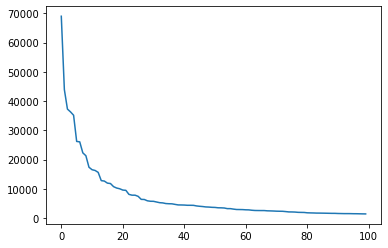

In [14]:
# Affichage des 100 mots les plus apparus dans les phrases
print(dico.most_common(100))
freq = [f for w,f in dico.most_common(100)]

plt.plot(freq)

Question qui devient de plus en plus intéressante avec les approches modernes:
est-il possible d'extraire des tri-grammes de lettres pour représenter nos documents?

Quelle performances attendrent? Quels sont les avantages et les inconvénients d'une telle approche?

# Modèles de Machine Learning

Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

In [20]:
# Séparation train / test
X_train, X_test, y_train, y_test = train_test_split(alltxts, alllabs, test_size=0.3, random_state=0)

# On ajoute à liste_donnees différents jeux de données issus de différents pré-traitements
liste_donnees = []

# Données avec prétraitements basique (ponctuation/maj/accent)
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
liste_donnees.append([X_train_vec,y_train,X_test_vec,y_test,len(vectorizer.get_feature_names()), "Prétraitements basiques : "])

# Données sans stop-words (+ pré-traitements basiques)
vectorizer = CountVectorizer(stop_words = stop_words)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
liste_donnees.append([X_train_vec,y_train,X_test_vec,y_test,len(vectorizer.get_feature_names()), "Prétraitements basiques + stopwords : "])

# Données avec stemming (+ pré-traitements basiques + stop words)
X_train_1 = X_train.copy()
X_test_1 = X_test.copy()
stemming(X_train_1)
stemming(X_test_1)
vectorizer = CountVectorizer(stop_words = stop_words)
X_train_vec = vectorizer.fit_transform(X_train_1)
X_test_vec = vectorizer.transform(X_test_1)
liste_donnees.append([X_train_vec,y_train,X_test_vec,y_test,len(vectorizer.get_feature_names()), "Prétraitements basiques + stopwords + stemming : "])

# Données sans stop-words (+ pré-traitement basiques)
#vectorizer = CountVectorizer(stop_words = stop_words, analyzer = 'word', min_df = 0.000001, max_df = 1)
#X = vectorizer.fit_transform(alltxts)
#liste_donnees.append([X,alllabs,len(vectorizer.get_feature)])

# Données n-gram niveau caractère (+ pré-traitement basiques)
#vectorizer = CountVectorizer(stop_words = stop_words, analyzer = 'char', min_df = 0.000001, max_df = 1)
#X = vectorizer.fit_transform(alltxts)
#liste_donnees.append([X,alllabs,len(vectorizer.get_feature)])

/Users/etienneperez/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [29]:
from sklearn.linear_model import LogisticRegression
scores = [] # Liste où on stocke les scores 
for liste in liste_donnees:

    # Pour chaque classifieur, on optimise ses paramètres en train avec gridSearch puis on calcule score f1 en test.
    ## Linear SVM 
    clf_svm = svm.LinearSVC(random_state=0, tol=1e-5)
    clf_svm.fit(liste[0],liste[1])
    
    ## Naive Bayes
    clf_nb = nb.MultinomialNB()
    clf_nb.fit(liste[0],liste[1])

    ## logistic regression
    clf_log = LogisticRegression(max_iter=1000)
    clf_log.fit(liste[0],liste[1])
    
    print(liste[5])
    print("taille vocabulaire : ",liste[4])
    print("Score f1 linear SVM : ",f1_score(clf_svm.predict(liste[2]),liste[3]))
    print("Score f1 naive Bayes : ",f1_score(clf_nb.predict(liste[2]),liste[3]))
    print("Score f1 logistic regression : ",f1_score(clf_log.predict(liste[2]),liste[3]))
    

/Users/etienneperez/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Prétraitements basiques : 
taille vocabulaire :  23703
Score f1 linear SVM :  0.9349698109472434
Score f1 naive Bayes :  0.9387755102040817
Score f1 logistic regression :  0.943955475019415
Prétraitements basiques + stopwords : 
taille vocabulaire :  23591
Score f1 linear SVM :  0.9342763157894737
Score f1 naive Bayes :  0.9396378269617706
Score f1 logistic regression :  0.9433134376512341


/Users/etienneperez/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Prétraitements basiques + stopwords + stemming : 
taille vocabulaire :  15736
Score f1 linear SVM :  0.9358549936084434
Score f1 naive Bayes :  0.9389395275899245
Score f1 logistic regression :  0.942621625989979


## Première campagne d'expériences

Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

## Equilibrage des données

Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.